In [33]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
from utils import misc
import datetime as dt

from simple_backtester import backTester
df = pd.read_csv('datasets/daily_price_series/SPY.csv')
df = misc.clean_df(df)
df = df.set_index('date')

In [34]:
df[['adjclose', 'close']]

,adjclose,close
date,,
1993-01-29,25.122364,43.937500
1993-02-01,25.301012,44.250000
1993-02-02,25.354612,44.343750
1993-02-03,25.622643,44.812500
1993-02-04,25.729851,45.000000
...,...,...
2023-05-02,410.839996,410.839996
2023-05-03,408.019989,408.019989
2023-05-04,405.130005,405.130005


In [35]:
bt = backTester()


df['signal'] = df['close'].rolling(10).mean() - df['close'].rolling(20).mean()
df['signal+1'] = df['signal'].shift(1)

bt.set_asset(df)

trade_list = []
for i in range(len(df)):
    if df['signal'][i] < 0 and df['signal+1'][i] > 0:
        trade_list.append(1)
    elif df['signal'][i] > 0 and df['signal+1'][i] < 0:
        trade_list.append(-1)
    else:
        trade_list.append(0)

df['trade_list'] = trade_list
for i in range(len(trade_list)):
    if bt.open_trade == None:
        if trade_list[i] > 0:
            order_quantity = (bt.cash // bt.adjclose[i]) * trade_list[i]
        else:
            order_quantity = 0
    else:
        if trade_list[i] == -1 or bt.date[i] - bt.open_trade.entry_date > dt.timedelta(days=60):
            order_quantity = bt.position * -1
        else:
            order_quantity = 0
    bt.take_action(order_quantity=order_quantity)

        


end


Annualised return: 1.0382809060318867
Sharpe ratio:      6.982611900439019
{'num_wins': 133, 'num_loss': 54, 'win_rate': 0.7112299465240641, 'profit': 2085133.0049915323, 'profit_mean': 11150.443876960066, 'returns_mean': 0.006986551324158421, 'returns_std': 0.041868570727986984, 'time_in_trade_mean': 22.518716577540108, 'time_in_trade_std': 14.744177726770477, 'capital_at_risk_mean': 1630802.5677482176, 'win_returns_mean': 0.02460441411405487, 'win_returns_std': 0.018926551682163593, 'win_profit_mean': 40026.15751744034, 'win_time_in_trade_mean': 16.94736842105263, 'win_time_in_trade_std': 9.203355604667513, 'loss_returns_mean': -0.03640559221391987, 'loss_returns_std': 0.050621104410450105, 'loss_profit_mean': -59969.36934866728, 'loss_time_in_trade_mean': 36.24074074074074, 'loss_time_in_trade_std': 16.799522887637945}


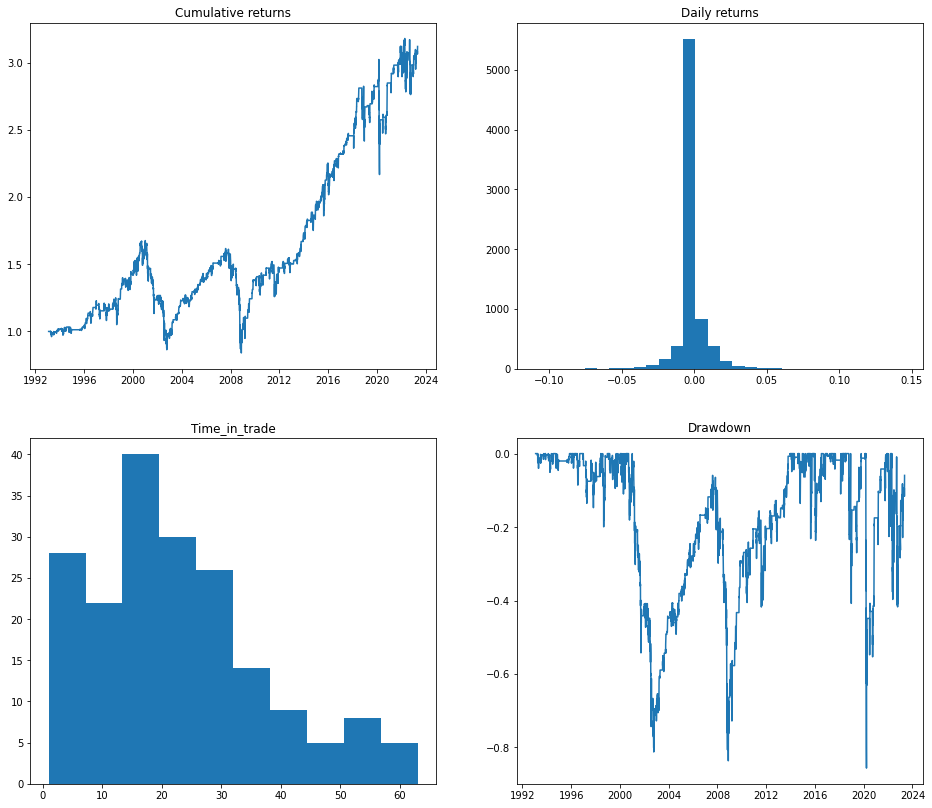

In [36]:
bt.results_analysis()

bt.plot_graphs()



In [37]:
bt.trade_record.stats

{'num_wins': 133,
 'num_loss': 54,
 'win_rate': 0.7112299465240641,
 'profit': 2085133.0049915323,
 'profit_mean': 11150.443876960066,
 'returns_mean': 0.006986551324158421,
 'returns_std': 0.041868570727986984,
 'time_in_trade_mean': 22.518716577540108,
 'time_in_trade_std': 14.744177726770477,
 'capital_at_risk_mean': 1630802.5677482176,
 'win_returns_mean': 0.02460441411405487,
 'win_returns_std': 0.018926551682163593,
 'win_profit_mean': 40026.15751744034,
 'win_time_in_trade_mean': 16.94736842105263,
 'win_time_in_trade_std': 9.203355604667513,
 'loss_returns_mean': -0.03640559221391987,
 'loss_returns_std': 0.050621104410450105,
 'loss_profit_mean': -59969.36934866728,
 'loss_time_in_trade_mean': 36.24074074074074,
 'loss_time_in_trade_std': 16.799522887637945}

In [38]:
bt.trade_record.records['time_in_trade']

0      48
1      23
2       4
3      18
4      21
       ..
182    50
183    22
184    56
185    28
186    35
Name: time_in_trade, Length: 187, dtype: int32

<AxesSubplot:>

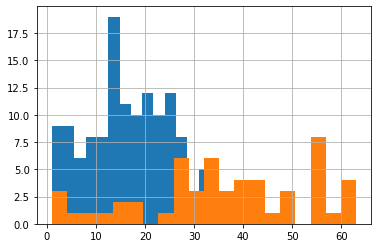

In [39]:
bt.trade_record.win_records['time_in_trade'].hist(bins=20)
bt.trade_record.loss_records['time_in_trade'].hist(bins=20)

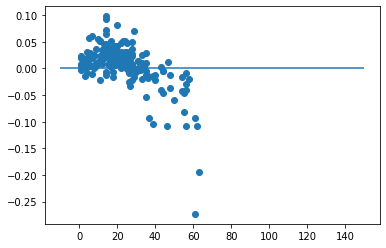

In [40]:
plt.scatter(bt.trade_record.records['time_in_trade'], bt.trade_record.records['returns'])
plt.hlines(0, -10, 150)